In [40]:
using QSWalk
using Graphs
using Plots
using GraphPlot
using LinearAlgebra
using Optim
using Colors

### QAOA

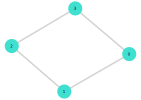

In [126]:
n = 2
g = cycle_graph(2^n)
adj = Matrix(adjacency_matrix(g))
gplot(g,nodelabel=0:(2^n-1))

In [129]:
function int_to_binary(num, n)
    binary_string = string(num, base=2)
    padding = max(0, n - length(binary_string))
    "0"^padding * binary_string
end

function RX(theta)
    [cos(theta/2)  -1im*sin(theta/2);
        -1im*sin(theta/2)  cos(theta/2)]
end

function maxcut_cost(g, x)
    c = 0
    for i in 1:size(g,1)
        for j in i:size(g,2)
            c += g[i,j] * ((parse(Int, x[i]) + parse(Int, x[j]) - 2 * parse(Int, x[i]) * parse(Int, x[j])))
        end
    end
    -c
end

function cost_hamiltonian(g)
    n = size(g,1)
    hc = zeros(Int, 2^n, 2^n)
    for i in 0:(2^n - 1)
        binary_string = int_to_binary(i, n)
        hc[i + 1, i + 1] = maxcut_cost(g, binary_string)
    end
    hc
end

function mixer_hamiltonian(g, beta)
    n = size(g,1)
    hb = RX(2 * beta)
    for i in 2:n
        hb = kron(hb, RX(2 * beta))
    end
    hb
end

function compute_expectation(g, counts)
    avg = 0
    for i in keys(counts)
        avg += maxcut_cost(g, i) * counts[i]
    end
    avg
end

function measure(v)
    d = Dict{String, Float64}()
    n = length(v)
    for i in 0:(n - 1)
        state = int_to_binary(i, convert(Int, floor(log2(n))))
        d[state] = abs(v[i + 1])^2
    end
    d
end

function qaoa(g, theta)
    n = size(g,1)
    p = div(length(theta), 2)
    gamma = theta[1:p]
    beta = theta[(p + 1):end]
    # Initial state
    v = ones(ComplexF64, 2^n) / sqrt(2^n)
    for i in 1:p
        hc = exp(-1im * gamma[i] * cost_hamiltonian(g))
        hb = mixer_hamiltonian(g, beta[i])
        v = hb * (hc * v)
    end
    v
end

function get_expectation(g)
    function execute_qaoa(theta)
        counts = measure(qaoa(g, theta))
        compute_expectation(g, counts)
    end
    execute_qaoa
end
    
function plot_cut(g,counts)
    values_array = collect(values(counts))
    max_value = maximum(values_array)
    max_key = findfirst(x -> x == max_value, values_array)
    key_with_max_value = collect(keys(counts))[max_key]
    red = parse(Colorant, "#00BAD2")
    blue = parse(Colorant, "#E43C38")
    node_colors = []
    for i in 1:size(g,1)
        if key_with_max_value[i] == '1'
            push!(node_colors, red)
        else
            push!(node_colors, blue)
        end
    end
    gplot(g,nodelabel=0:size(g,1)-1,nodefillc=node_colors)
end

plot_cut (generic function with 1 method)

In [130]:
p = 1
theta_init = ones(2 * p)
expectation = get_expectation(adj)
# Minimize the expectation function
res = optimize(expectation, theta_init, NelderMead())
counts = measure(qaoa(adj, res.minimizer))

Dict{String,Float64} with 16 entries:
  "0011" => 0.0781204
  "0110" => 0.0781204
  "1100" => 0.0781204
  "1011" => 0.0156285
  "0001" => 0.0156285
  "1001" => 0.0781204
  "1101" => 0.0156285
  "1110" => 0.0156285
  "1010" => 0.265623
  "0010" => 0.0156285
  "0101" => 0.265623
  "1111" => 0.0156227
  "1000" => 0.0156285
  "0100" => 0.0156285
  "0000" => 0.0156227
  "0111" => 0.0156285

In [4]:
function plot_qaoa(counts)
    x_values = collect(keys(counts))
    y_values = collect(values(counts))
    bar(x_values, y_values, xlabel="Solutions", ylabel="Probability", legend=false)
end

plot_qaoa (generic function with 1 method)

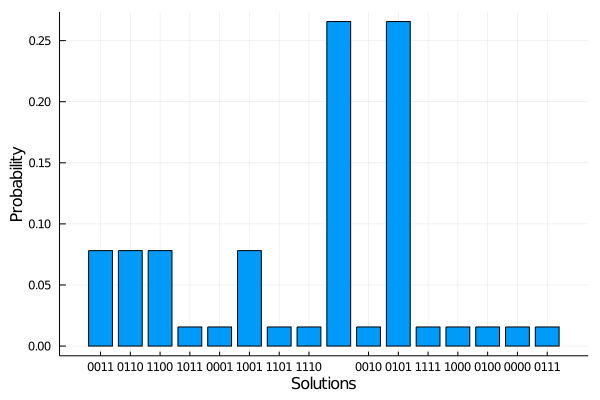

In [60]:
plot_qaoa(counts)

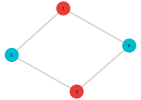

In [61]:
plot_cut(g,counts)

### QAOA with density operators

In [19]:
function dagger(m)
    adjoint(m)
end

function density(v)
    n = length(v)
    rho = zeros(ComplexF64, n, n)
    for i in 1:n
        for j in 1:n
            rho[i, j] = v[i] * conj(v[j])
        end
    end
    rho
end

function trace(rho)
    t = 0
    for i in 1:size(rho,1)
        t += rho[i, i]
    end
    return t
end

function measure_dens(rho)
    d = Dict{String, Float64}()
    n = size(rho,1)
    for i in 0:(n - 1)
        state = int_to_binary(i, convert(Int, floor(log2(n))))
        d[state] = real(rho[i+1, i+1])
    end
    d
end

function qaoa_dens(g, theta)
    n = size(g,1)
    p = div(length(theta), 2)
    gamma = theta[1:p]
    beta = theta[(p + 1):end]
    # Initial state
    v = ones(ComplexF64, 2^n) / sqrt(2^n)
    rho = density(v)
    w = 0
    lind_local = local_lind(g)
    op_local = evolve_generator(g, lind_local, w)
    for i in 1:p
        hc = exp(-1im * gamma[i] * cost_hamiltonian(g))
        hb = mixer_hamiltonian(g, beta[i])
        rho = hc * rho * dagger(hc)
        #rho = hb * rho * dagger(hb)
        rho = evolve(op_local, rho, beta[i])
    end
    rho
end

function get_expectation_dens(g)
    function execute_qaoa_dens(theta)
        counts = measure_dens(qaoa_dens(g, theta))
        compute_expectation(g, counts)
    end
    execute_qaoa_dens
end

get_expectation_dens (generic function with 1 method)

In [23]:
p = 1
theta_init = ones(2 * p)
expectation = get_expectation_dens(adj)
# Minimize the expectation function
res = optimize(expectation, theta_init, NelderMead())
counts = measure_dens(qaoa_dens(adj, res.minimizer))

AssertionError: [91mAssertionError: The initial state size should be square root of evolve_generator size[39m

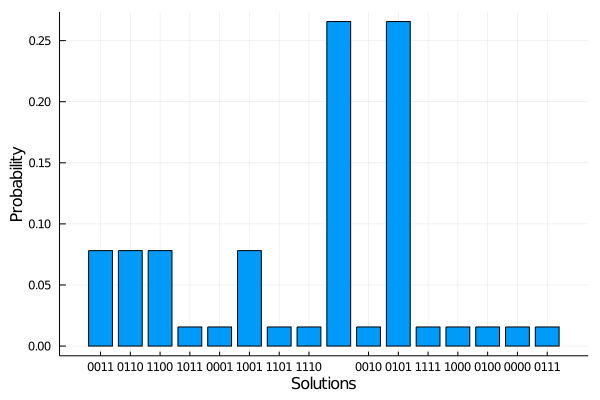

In [21]:
plot_qaoa(counts)

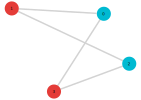

In [8]:
plot_cut(g,counts)

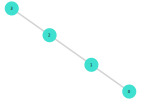

In [210]:
n = 2
w = 0
time = 1.0
g = path_graph(2^n)
adjacency = adjacency_matrix(g);
v = ones(ComplexF64, 2^n) / sqrt(2^n)
rho = proj(1,2^n) #density(v)
gplot(g,nodelabel=0:2^n-1)

In [215]:
Matrix(adjacency)

4×4 Array{Int64,2}:
 0  1  0  0
 1  0  1  0
 0  1  0  1
 0  0  1  0

In [213]:
lind_local = local_lind(adjacency)
op_local = evolve_generator(adjacency, lind_local, w)
#hc = exp(-1im * 1 * cost_hamiltonian(adjacency))
#rho = hc * rho * dagger(hc)
rho = evolve(op_local, pj, time)

4×4 Transpose{Complex{Float64},Array{Complex{Float64},2}}:
  0.332585+0.0im              0.0+0.407063im  …        0.0-0.0825823im
       0.0-0.407063im    0.498218+0.0im          -0.101075+0.0im
 -0.222379+0.0im              0.0-0.272178im           0.0+0.0552177im
       0.0+0.0825823im  -0.101075+0.0im          0.0205055+0.0im

In [197]:
cost_hamiltonian(adjacency)

16×16 Array{Int64,2}:
 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  0
 0  -2   0   0   0   0   0   0   0   0   0   0   0   0   0  0
 0   0  -2   0   0   0   0   0   0   0   0   0   0   0   0  0
 0   0   0  -2   0   0   0   0   0   0   0   0   0   0   0  0
 0   0   0   0  -2   0   0   0   0   0   0   0   0   0   0  0
 0   0   0   0   0  -4   0   0   0   0   0   0   0   0   0  0
 0   0   0   0   0   0  -2   0   0   0   0   0   0   0   0  0
 0   0   0   0   0   0   0  -2   0   0   0   0   0   0   0  0
 0   0   0   0   0   0   0   0  -2   0   0   0   0   0   0  0
 0   0   0   0   0   0   0   0   0  -2   0   0   0   0   0  0
 0   0   0   0   0   0   0   0   0   0  -4   0   0   0   0  0
 0   0   0   0   0   0   0   0   0   0   0  -2   0   0   0  0
 0   0   0   0   0   0   0   0   0   0   0   0  -2   0   0  0
 0   0   0   0   0   0   0   0   0   0   0   0   0  -2   0  0
 0   0   0   0   0   0   0   0   0   0   0   0   0   0  -2  0
 0   0   0   0   0   0   0   0   0   0   0   0  

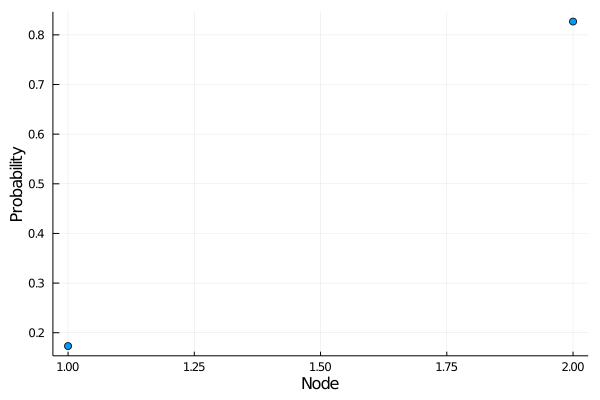

In [192]:
positions = (collect(1:n))
scatter(positions, real.(diag(rho)),legend=false) #ylims=(0, 1)
xlabel!("Node")
ylabel!("Probability")

2